In [18]:
import numpy as np
import pandas as pd
import lennardjones as lj

import scipy.stats
import matplotlib.pyplot as plt

## Import the data

In [101]:
df_dataframe = pd.read_csv('/Users/alysonspitzig/Documents/GitHub/nc_AFM/lennardjones/example_data/df_dataframe_237K.csv')

z_piezo = np.genfromtxt('/Users/alysonspitzig/Documents/GitHub/nc_AFM/lennardjones/example_data/z_piezo.csv')


In [102]:
a = 0.5*10**-9
k = 1800
f_0 = 19796.5
noise = 0.5 #Hz , 1 Hz peak to peak

z_real = z_piezo - z_piezo[0] +1*10**(-9)

In [103]:
def calculate_force(a,k,f_0, z, df_data):
    
    '''
    calculates force from given frequency shift data and corresponding z positions.
    Notice, the absolute value of the force does not depend on the absolute value of the z position,
    just the difference between sequential z positions. Therefore the z input can be the 'piezo' z position;
    it doens't have to be relative to the sample.
    
    Inputs:
    -------
    a: float. amplitude of oscillation in units of m
    k: spring constant of the AFM tip. in untis of N/m
    f_0: reasonant frequency of the AFM tip. in Hz.
    z: ndarray of the height of the tip. It does not need to be height with respect to sample,
        but the differences between heights need to be accurate.
    df_data: frequency shift data at corresponding z positions. In units of Hz. 
    
    Returns:
    --------
    force_array: ndarray (of size z) of the corresponding force, calculated using the method outlined
        by Sader and Jarvis (2004) DOI: 10.1063/1.1667267 Eg (9)
    
    '''
    
    root_amplitude = np.sqrt(a)

    const_2 = root_amplitude / (8*np.sqrt(np.pi)) #units sqrt m
    const_3 = root_amplitude**3 / np.sqrt(2)      #units m * sqrt m

    xdata = z
    ydata = df_data
    
    new_size = len(z) -1

    #creat empty array to store the calculation in
    force_array = np.zeros([new_size])
    
    Omega = ydata / f_0
    Omegadz = np.gradient(Omega) / np.gradient(xdata)

    first_term = np.zeros([new_size])
    second_term = np.zeros([new_size])
    third_term = np.zeros([new_size])
    correction_term = np.zeros([new_size])

    for zi in range(0, new_size):
        t = zi+1
        root_t_z = np.sqrt((xdata[t:] - xdata[zi]))
    
        integral_1 = np.trapz((Omega[t:]), x = xdata[t:]) 
        integral_2 = np.trapz(((const_2 / root_t_z) * Omega[t:]), x = xdata[t:])     
        integral_3 = np.trapz(- (const_3 / root_t_z * Omegadz[t:]), x = xdata[t:])
        
        first_term[zi] = 2 * k * (integral_1)
        second_term[zi] = 2 * k * (integral_2)
        third_term[zi] = np.real(2 * k * (integral_3))
    
        # correction terms for t=z from [2] mathematica notebook SJ
        corr1 = Omega[zi] * (xdata[t]-xdata[zi])
        corr2 = 2 * const_2 * Omega[zi] * np.sqrt(xdata[t] - xdata[zi])
        corr3 = -2 * const_3 * Omegadz[zi] * np.sqrt(xdata[t] - xdata[zi])
        correction_term[zi] = 2 * k * (corr1 + corr2 + corr3)
    
    force_array = first_term+second_term+third_term+correction_term
    
    return force_array

In [105]:
force_0p75 = calculate_force(a,k,f_0, z_real, df_dataframe['0.75'])

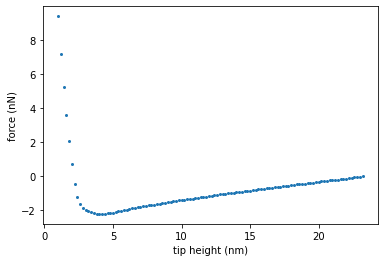

In [106]:
plt.scatter(z_real[:-1]*10**9, calculate_force(a,k,f_0, z_real, df_dataframe['0.75'])*10**9, s= 4, label = '0.75 V')
plt.ylabel('force (nN)')
plt.xlabel('tip height (nm)');

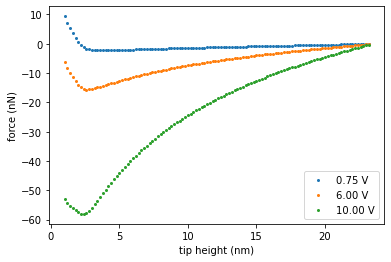

In [108]:
plt.scatter(z_real[:-1]*10**9, calculate_force(a,k,f_0, z_real, df_dataframe['0.75'])*10**9, s= 4, label = '0.75 V')

plt.scatter(z_real[:-1]*10**9, calculate_force(a,k,f_0, z_real, df_dataframe['6.0'])*10**9, s= 4, label = '6.00 V')

plt.scatter(z_real[:-1]*10**9, calculate_force(a,k,f_0, z_real, df_dataframe['10.0'])*10**9, s= 4, label = '10.00 V')

plt.ylabel('force (nN)')
plt.xlabel('tip height (nm)')
plt.legend();

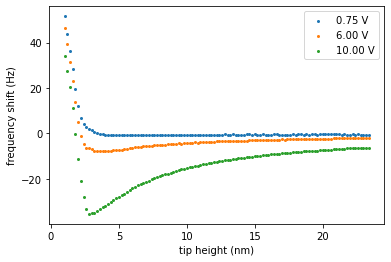

In [109]:
plt.scatter(z_real*10**9, df_dataframe['0.75'], s= 4, label = '0.75 V')

plt.scatter(z_real*10**9, df_dataframe['6.0'], s= 4, label = '6.00 V')

plt.scatter(z_real*10**9, df_dataframe['10.0'], s= 4, label = '10.00 V')

plt.ylabel('frequency shift (Hz)')
plt.xlabel('tip height (nm)')

plt.legend();

In [110]:
upper = calculate_force(a,k,f_0, z_real, df_dataframe['0.75']+0.2)*10**9
lower = calculate_force(a,k,f_0, z_real, df_dataframe['0.75']-0.2)*10**9

In [111]:
error = (upper-lower)/2

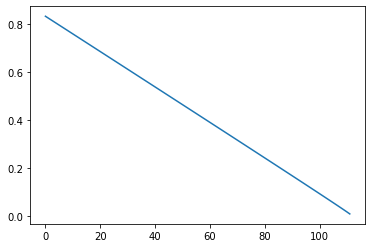

In [112]:
plt.plot(error)

## Generate some time trace data to simulate the background noise

The peak to peak noise of the tip is typically ~ 1 Hz. However, this noise is on the time scale of the reasonant frequency ($f_0$).

The measurement itself occurs on the scale of 0.0125 s. The data is collected via a bias sweep ranging from -10 to 10 V in approximately 10 s. One of such data points (at 0.75 V for example) is taken to be a part of the above trace. Therefore, the time average for one data point is 10s/801 ~ 0.0125 s per data point.

In [113]:
noise = 0.5

In [114]:
test_time = np.arange(0,1+1/f_0,1/f_0)

test_noise = scipy.stats.norm.rvs(loc=0, scale = noise, size = len(test_time))

Text(0.5, 0, 'time(s)')

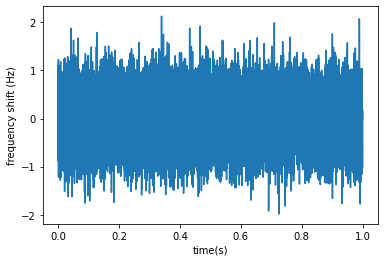

In [115]:
plt.plot(test_time, test_noise)

plt.ylabel('frequency shift (Hz)')
plt.xlabel('time(s)')

That is actaully ... quite similar to the noise we see.

Now what noise do we see when we average over 0.0125 s? 0.125 = 1.25e-2

In [116]:
np.shape(test_time)

(19798,)

In [117]:
np.shape(np.arange(0,1,0.0125))

(80,)

In [126]:
print(19800/80, ',', 19800/80*2)

247.5 , 495.0


~247.5 indices to average over for a 0.0125s average. Or ~495 indices for a 0.025s average, then divide by two. 

In [127]:
window_to_average_over = np.ones([495])

In [130]:
noise_averaged = np.convolve(np.abs(test_noise), window_to_average_over, 'valid') / 495 /2

In [131]:
np.mean(noise_averaged)

0.19981131603695393